In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from keras.utils.np_utils import normalize
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify


In [2]:
os.chdir('E:\\PlotDel_Steven\\sen_proj')
from fpackage.resnet50_unet import DataGen, build_resnet50_unet

In [3]:
data_dir= "../"
dataset_path = data_dir + "Data/dataset"

In [4]:
input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)
model.load_weights(dataset_path + "/ResNet_UNet.h5",compile = false)
#model.summary()

In [5]:
import matplotlib.pyplot as plt

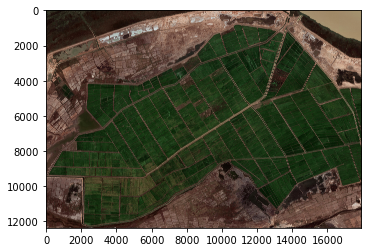

In [6]:
#Apply a trained model on large image
test_image = cv2.imread(r"E:\PlotDel_Steven\Data\out.tif") #BGR
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#test_image = cv2.resize(test_image, (12288, 12288))

#This will split the image into small images of shape [3,3]
patches = patchify(test_image, (512,512, 3), step=512)  #Step=512 for 512 patches means no overlap
plt.imshow(test_image)

In [9]:
test_image.shape

(12365, 17920, 3)

In [13]:
17920/5

3584.0

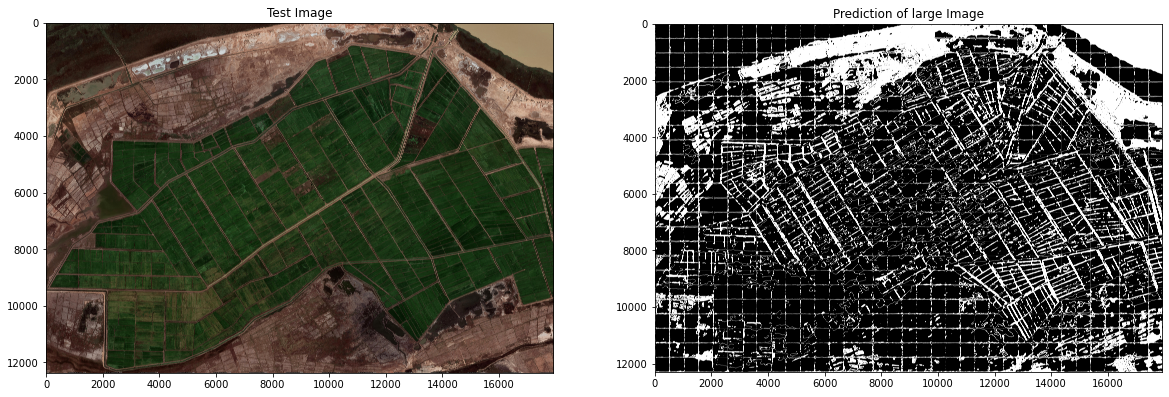

In [7]:
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        #print(i,j)

        single_patch = patches[i, j, 0, :, :, :]       
        single_patch = np.expand_dims(single_patch, axis=0) #very important
        single_patch = single_patch/255.0
        result = (model.predict(single_patch))#astype(np.uint8)
        result = result > 0.0199919999999995
        result = np.reshape(result*255, (512, 512))
        #single_patch_predicted_img = np.argmax(result, axis=3)[0,:,:]

        predicted_patches.append(result)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], 
                                                            patches.shape[1],
                                                            patches.shape[2], 
                                                            512,512
                                                            ))
#predicted_patches_reshaped = np.expand_dims(predicted_patches_reshaped, axis=5) #introduce channel

predicted_patches_reshaped = np.stack((predicted_patches_reshaped,)*3, axis=-1).astype(np.uint8)


#get the correct shape
p = predicted_patches_reshaped.shape[0]*512,predicted_patches_reshaped.shape[1]*512
#predicted_patches_reshaped = unpatchify(predicted_patches_reshaped, test_image.shape)
reconstructed_image = unpatchify(predicted_patches_reshaped,cv2.resize(test_image, (int(p[1]),int(p[0]))).shape)


plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.title('Test Image')
plt.imshow(test_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

In [8]:
plt.imsave('E:\\PlotDel_Steven\\sen_proj\\prediction_25012022.png', reconstructed_image, cmap='gray')


In [15]:
model

(12365, 17920, 3)

In [18]:

p = predicted_patches_reshaped.shape[0]*512,predicted_patches_reshaped.shape[1]*512
test_image = cv2.resize(test_image, (int(p[1]),int(p[0])))
test_image = test_image/255.0
test_image.shape

(12288, 17920, 3)

In [21]:


from smooth_tiled_predictions import predict_img_with_smooth_windowing

original_mask = cv2.imread(r"E:\PlotDel_Steven\Data\out.tif")
original_mask = original_mask[:,:,0]  #Use only single channel...

# size of patches
patch_size = 512

# Number of classes 
n_classes = 2

         
###################################################################################
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    original_mask,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


#final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
#plt.imsave('data/test_images/N-34-66-C-c-4-3.tif_segmented.jpg', final_prediction)
#plt.imsave('data/test_images/N-34-66-C-c-4-3.tif_mask.jpg', original_mask)
###################


plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()

#############################


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2) and requested shape (2,2)